In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import glob
import os
import random
import timm
import torchvision.utils as vutils

from PIL import Image
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report, accuracy_score, precision_score, recall_score, f1_score

import seaborn as sns
import pandas as pd


In [2]:
# !nvidia-msi

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
train_path = "/kaggle/input/fracturedataset/Bone_Fracture_Binary_Classification/train"
val_path = "/kaggle/input/fracturedataset/Bone_Fracture_Binary_Classification/val"


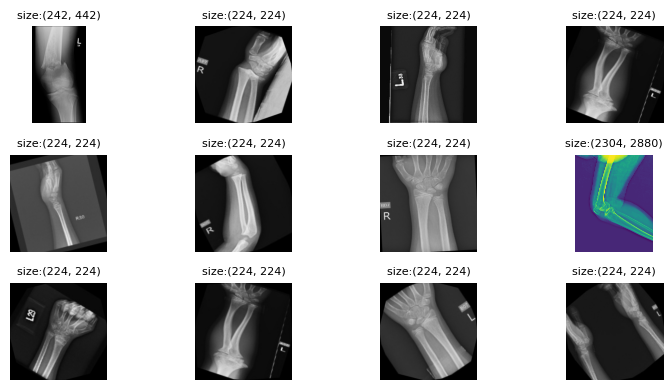

In [5]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


# Hàm lấy đường dẫn ảnh
def get_image_paths(folder_path):
    image_paths = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))
    return image_paths

# Hàm hiển thị dữ liệu
def display_dataset(path, num_images=12):
    random.seed(322)
    images_paths = get_image_paths(path)
    random_images = random.sample(images_paths, num_images)
    fig, axes = plt.subplots(3, 4, figsize=(8, 4))

    for i, ax in enumerate(axes.flat):
        image_path = random_images[i]
        image = Image.open(image_path)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"size:{image.size}", fontsize=8)

    plt.tight_layout()
    plt.show()

# display_dataset(train_path)
display_dataset(val_path)

In [6]:
# Chỉnh sửa HandleTransparency để xử lý hình ảnh với kênh alpha hoặc chế độ màu khác
class HandleTransparency(object):
    def __call__(self, img):
        if img.mode == 'RGBA' or img.mode == 'LA':
            img = img.convert('L')
        elif img.mode == 'P':
            img = img.convert('RGBA')
            img = img.convert('L')
        else:
            img = img.convert('L')
        return img


In [7]:

# Cấu hình transform cho tập huấn luyện và tập kiểm tra
train_transforms = v2.Compose([
    HandleTransparency(),  # Thêm lớp xử lý chuyển đổi màu sắc
    v2.Grayscale(1),
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(10),
    v2.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2)),
    v2.RandomEqualize(0.2),
    v2.RandomInvert(0.1),
    v2.ToTensor(),
])

val_transforms = v2.Compose([
    HandleTransparency(),  # Thêm lớp xử lý chuyển đổi màu sắc
    v2.Grayscale(1),
    v2.Resize((224, 224)),
    v2.ToTensor(),
])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Số lượng lớp trong tập huấn luyện: 2
Các lớp trong tập huấn luyện: ['fractured', 'not fractured']
Số lượng lớp trong tập kiểm tra: 2
Các lớp trong tập kiểm tra: ['fractured', 'not fractured']


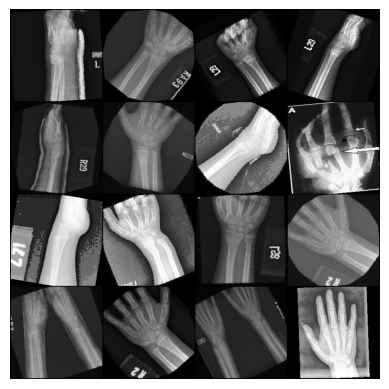

device(type='cuda')

In [8]:
# Tạo dataset và dataloader
train_ds = ImageFolder(train_path, transform=train_transforms)
val_ds = ImageFolder(val_path, transform=val_transforms)

# Kiểm tra và in ra số lượng lớp và tên các lớp
print(f"Số lượng lớp trong tập huấn luyện: {len(train_ds.classes)}")
print(f"Các lớp trong tập huấn luyện: {train_ds.classes}")

print(f"Số lượng lớp trong tập kiểm tra: {len(val_ds.classes)}")
print(f"Các lớp trong tập kiểm tra: {val_ds.classes}")

train_dataloader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=64, shuffle=False)

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

dataiter = iter(train_dataloader)
images, _ = next(dataiter)

imshow(vutils.make_grid(images[:16], nrow=4))

# Kiểm tra kênh và kích thước ảnh
# images[0].shape

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [9]:
# Tạo mô hình sử dụng `timm` và cấu hình lại để phù hợp với dữ liệu đầu vào
model = timm.create_model("deit3_small_patch16_224.fb_in22k_ft_in1k", pretrained=True, num_classes=2)

for param in model.parameters():
    param.requires_grad = False

for param in model.blocks[11].parameters():
    param.requires_grad = True

model.head.requires_grad = True

outc = model.patch_embed.proj.out_channels
kernel_size = model.patch_embed.proj.kernel_size
stride = model.patch_embed.proj.stride
# Chỉnh sửa lớp patch_embed.proj để phù hợp với kênh đầu vào là 1 (grayscale)
model.patch_embed.proj = nn.Conv2d(in_channels=1,
                            out_channels=outc,
                            kernel_size=kernel_size,
                            stride=stride)

model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=4, gamma=0.5)

model.safetensors:   0%|          | 0.00/88.3M [00:00<?, ?B/s]

In [10]:
# Hàm huấn luyện cho một epoch
def train_one_epoch(model, train_dataloader, criterion, optimizer):
    model.train()

    total_loss = 0
    for images, labels in tqdm(train_dataloader):

        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    return avg_loss


In [11]:

# Hàm kiểm tra mô hình
def validate(model, val_dataloader, criterion):
    model.eval()

    with torch.no_grad():

        total_loss = 0
        correct = 0
        all_labels = []
        all_predictions = []

        for images, labels in tqdm(val_dataloader):

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        accuracy = 100 * correct / len(val_dataloader.dataset)
        avg_loss = total_loss / len(val_dataloader)

    return avg_loss, accuracy, all_labels, all_predictions


In [12]:

# Hàm huấn luyện toàn bộ mô hình
def train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=20):
    train_losses = []
    val_losses = []
    accuracies = []
    all_labels = []
    all_predictions = []
    for epoch in range(num_epochs):

        train_loss = train_one_epoch(model, train_dataloader, criterion, optimizer)
        val_loss, accuracy, epoch_labels, epoch_predictions = validate(model, val_dataloader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        accuracies.append(accuracy)

        all_labels.extend(epoch_labels)
        all_predictions.extend(epoch_predictions)

        scheduler.step()

        print(f'Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Accuracy:{accuracy:2f}%')

    return train_losses, val_losses, accuracies, all_labels, all_predictions


In [13]:
train_losses, val_losses, accuracies, all_labels, all_predictions = train(model, train_dataloader, val_dataloader, criterion, optimizer)


 31%|███       | 4/13 [00:03<00:07,  1.23it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch: 1/20 | Train Loss: 0.6692 | Val Loss: 0.5845 | Accuracy:70.205066%


100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


Epoch: 2/20 | Train Loss: 0.5994 | Val Loss: 0.4991 | Accuracy:79.734620%


100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


Epoch: 3/20 | Train Loss: 0.5388 | Val Loss: 0.5275 | Accuracy:73.100121%


100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Epoch: 4/20 | Train Loss: 0.5171 | Val Loss: 0.4189 | Accuracy:81.423402%


100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


Epoch: 5/20 | Train Loss: 0.4538 | Val Loss: 0.4047 | Accuracy:82.267793%


100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Epoch: 6/20 | Train Loss: 0.4242 | Val Loss: 0.3749 | Accuracy:82.991556%


100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


Epoch: 7/20 | Train Loss: 0.4102 | Val Loss: 0.3628 | Accuracy:83.353438%


100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


Epoch: 8/20 | Train Loss: 0.3939 | Val Loss: 0.4100 | Accuracy:81.785283%


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


Epoch: 9/20 | Train Loss: 0.3611 | Val Loss: 0.3281 | Accuracy:85.524729%


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


Epoch: 10/20 | Train Loss: 0.3503 | Val Loss: 0.3049 | Accuracy:86.851628%


100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


Epoch: 11/20 | Train Loss: 0.3404 | Val Loss: 0.2837 | Accuracy:87.696019%


100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


Epoch: 12/20 | Train Loss: 0.3289 | Val Loss: 0.2859 | Accuracy:87.092883%


100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


Epoch: 13/20 | Train Loss: 0.3085 | Val Loss: 0.2710 | Accuracy:87.334138%


100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


Epoch: 14/20 | Train Loss: 0.3088 | Val Loss: 0.2781 | Accuracy:86.972256%


100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


Epoch: 15/20 | Train Loss: 0.3074 | Val Loss: 0.2523 | Accuracy:89.022919%


100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Epoch: 16/20 | Train Loss: 0.2904 | Val Loss: 0.2635 | Accuracy:88.178528%


100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


Epoch: 17/20 | Train Loss: 0.2870 | Val Loss: 0.2427 | Accuracy:89.143546%


100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


Epoch: 18/20 | Train Loss: 0.2850 | Val Loss: 0.2429 | Accuracy:88.540410%


100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


Epoch: 19/20 | Train Loss: 0.2816 | Val Loss: 0.2408 | Accuracy:88.902292%


100%|██████████| 13/13 [00:08<00:00,  1.62it/s]

Epoch: 20/20 | Train Loss: 0.2816 | Val Loss: 0.2509 | Accuracy:87.696019%


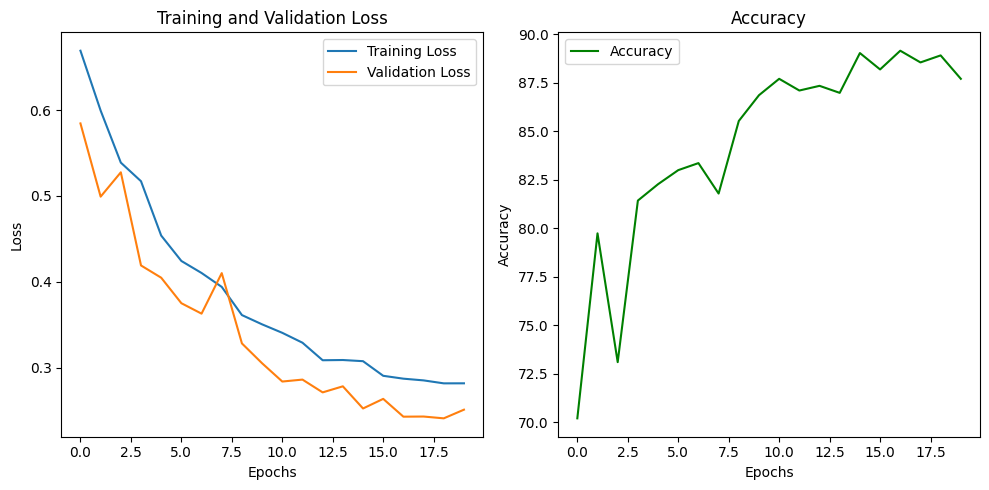

In [14]:

# Hàm vẽ đồ thị huấn luyện và kiểm tra
def plot_curves(train_losses, val_losses, accuracies):

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Accuracy', color='green')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_curves(train_losses, val_losses, accuracies)


In [15]:

# Thêm hàm để dự đoán hình ảnh bất kỳ
def predict_image(image_path, model, transforms, device):
    # Mở và chuyển đổi ảnh
    image = Image.open(image_path)
    image = transforms(image).unsqueeze(0)  # Thêm batch dimension

    # Chuyển ảnh sang device và dự đoán
    image = image.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()


In [16]:
import os

# Đường dẫn thư mục bạn muốn lưu
save_dir = 'FracturedDataResnet'

# Nếu thư mục chưa tồn tại thì tạo mới
os.makedirs(save_dir, exist_ok=True)

# Bây giờ save model thoải mái
save_path = os.path.join(save_dir, 'model.pt')

torch.save(model.state_dict(), save_path)

print(f"Model đã được lưu tại {save_path}")



Model đã được lưu tại FracturedDataResnet/model.pt


In [17]:

# Đường dẫn đến hình ảnh cần dự đoán
image_path = "/kaggle/input/fracturedataset/Bone_Fracture_Binary_Classification/test/fractured/0.png"

# Dự đoán lớp của hình ảnh
predicted_class = predict_image(image_path, model, val_transforms, device)
print(f"Dự đoán lớp của hình ảnh: {predicted_class} ({train_ds.classes[predicted_class]})")


Dự đoán lớp của hình ảnh: 1 (not fractured)


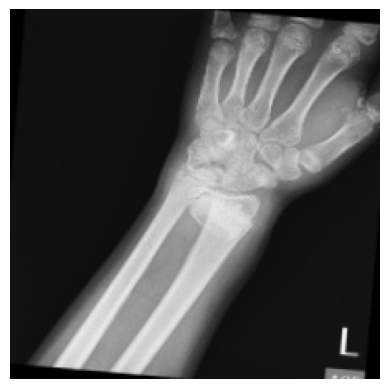

predict: 0 (fractured)
true label: fractured


In [18]:

import random

# Đường dẫn đến thư mục chứa ảnh kiểm tra
test_path = "/kaggle/input/fracturedataset/Bone_Fracture_Binary_Classification/test/"

# Chọn ngẫu nhiên một ảnh trong thư mục
image_path = random.choice(get_image_paths(test_path))

# Hiển thị ảnh
plt.imshow(Image.open(image_path))
plt.axis('off')
plt.show()

# Dự đoán lớp của ảnh
predicted_class = predict_image(image_path, model, val_transforms, device)

# Lấy nhãn thực sự của ảnh
true_class = image_path.split('/')[-2]

# In ra dự đoán và nhãn thực sự
print(f"predict: {predicted_class} ({train_ds.classes[predicted_class]})")
print(f"true label: {true_class}")


In [19]:
# prompt: create test_dataloader

test_transforms = v2.Compose([
    HandleTransparency(),  # Thêm lớp xử lý chuyển đổi màu sắc
    v2.Grayscale(1),
    v2.Resize((224, 224)),
    v2.ToTensor(),
])

test_ds = ImageFolder(test_path, transform=test_transforms)

test_dataloader = DataLoader(test_ds, batch_size=64, shuffle=False)


In [20]:

def measure_accuracy(model, dataloader):
    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0

        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return accuracy

print(measure_accuracy(model, val_dataloader))

print(measure_accuracy(model, test_dataloader))

87.69601930036188
84.18972332015811


In [21]:
def get_predictions(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred


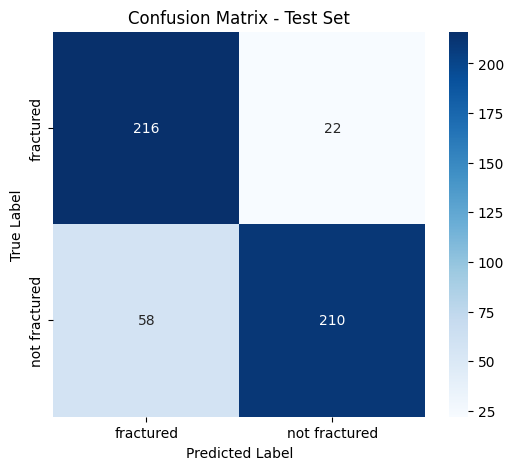

In [22]:
y_true, y_pred = get_predictions(model, test_dataloader)

# Tên lớp lấy từ test dataset
class_names = test_ds.classes

# Tạo confusion matrix
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(6, 5))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set")
plt.show()


In [23]:
# Lấy dự đoán trên test set
y_true, y_pred = get_predictions(model, test_dataloader)

# Tên các lớp
class_names = test_ds.classes

# In classification report chi tiết theo từng lớp
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))

# In tổng hợp các chỉ số chung (macro)
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("=== Overall Metrics (Macro Average) ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


=== Classification Report ===
               precision    recall  f1-score   support

    fractured       0.79      0.91      0.84       238
not fractured       0.91      0.78      0.84       268

     accuracy                           0.84       506
    macro avg       0.85      0.85      0.84       506
 weighted avg       0.85      0.84      0.84       506

=== Overall Metrics (Macro Average) ===
Accuracy : 0.8419
Precision: 0.8467
Recall   : 0.8456
F1 Score : 0.8419
